
https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection
https://stackoverflow.com/questions/3654289/scipy-create-2d-polygon-mask
https://scikit-image.org/docs/stable/api/skimage.transform.html#resize

In [10]:
import os

from PIL import Image, ImageDraw    
import skimage.io as sio
from skimage.transform import resize
import matplotlib.pyplot as plt
import json
import numpy as np

import cv2
import pandas as pd

In [2]:
xs = []
ys = []
for fname in os.listdir('TRAIN'):
    if not fname.endswith("jpg"):
        continue

    train = sio.imread(f'TRAIN/{fname}')

    shape = train.shape

    if len(shape) == 2:
        x, y = shape
    else:
        x, y, c = shape
        
    xs.append(x)
    ys.append(y)

In [3]:
with open('TRAIN/annotations_train.json', 'r') as f:
    my_dict = json.load(f)

In [4]:
shape_set = set()
region_set = set()

for _, data in my_dict.items():
    shape = data['regions'][0]['shape_attributes']['name']
    shape_set.add(shape)
    region_set.add(len(data['regions']))

In [5]:
shape_set, region_set

({'circle', 'ellipse', 'polygon'}, {1, 2, 3})

Note that there are three possible shapes of annotations. We have to define an appropriate mask for each type of the shape.

Also, there may exist multiple annotations in a mask. Hence, I will for-loop through each annotation.

In [6]:
for _, data in my_dict.items():

    for region in data['regions']:

        if region['region_attributes']:
            print(region['region_attributes'])

Nothing is printed. I wonder what region_attribute is for? 

In [7]:
for i in range(1, 500):

    mask = sio.imread(f'../masks/y{i}.png', as_gray=True)
    if 1 not in np.unique(mask):
        print(i)

In [34]:
def resize_img(input_path):
    
    img = sio.imread(input_path, as_gray=True)

    resized = cv2.resize(img, (288,320), interpolation=cv2.INTER_CUBIC)
    resized = (resized - resized.min())
    resized = resized / resized.max() * 255
    resized = resized.astype(np.uint8)

    return resized
    

In [50]:
if not os.path.exists('../data'):
    os.makedirs('../data')
    os.makedirs('../data/mask')
    os.makedirs('../data/train')
    os.makedirs('../data/val')

has_mask = set()

for _, data in my_dict.items():

    fname = data['filename']

    img = sio.imread(f'TRAIN/{fname}', as_gray=True)
    mask = Image.new('L', tuple(reversed(img.shape)), 0)

    for region in data['regions']:

        shape = region['shape_attributes']['name']
        
        if shape == 'polygon':

            all_x = region['shape_attributes']['all_points_x']
            all_y = region['shape_attributes']['all_points_y']

            polygon = [(x, y) for x, y in zip(all_x, all_y)]
            ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)

        elif shape == 'ellipse':

            cx = region['shape_attributes']['cx']
            cy = region['shape_attributes']['cy']
            rx = region['shape_attributes']['rx']
            ry = region['shape_attributes']['ry']

            ImageDraw.Draw(mask).ellipse([(cx-rx, cy-ry), (cx+rx, cy+ry)], outline=1, fill=1)

        elif shape == 'circle':

            cx = region['shape_attributes']['cx']
            cy = region['shape_attributes']['cy']
            r = region['shape_attributes']['r']

            ImageDraw.Draw(mask).ellipse([(cx-r, cy-r), (cx+r, cy+r)], outline=1, fill=1)

    mask = np.array(mask)

    # For some unfathomable reasons, resizing with skimage transform "shrinks" the ellipse case (y101.jpg)
    resized_mask = cv2.resize(mask, (288,320), interpolation=cv2.INTER_NEAREST).astype(np.uint8)
    resized = resize_img(f'TRAIN/{fname}')

    sio.imsave(f'../data/mask/{fname[:-4].lower()}_mask.png', resized_mask, check_contrast=False)
    sio.imsave(f'../data/mask/{fname[:-4].lower()}.png', resized, check_contrast=False)

    has_mask.add(fname)

# I want the images with mask treated separately

def resize_and_save(input_dir, output_dir, fnames):

    for fname in fnames:
        output_path = f'{output_dir}{fname[:-4].lower()}.png'
        resized = resize_img(f'{input_dir}{fname}')
        sio.imsave(output_path, resized)

yes = sorted(list(set(os.listdir('../yes')) - has_mask),
            key=lambda x: int(x[1:-4]))
no = sorted(list(set(os.listdir('../no'))),
            key=lambda x: int(x[2:-4]))

resize_and_save('../yes/', '../data/train/', yes[:-100])
resize_and_save('../no/', '../data/train/', no[:-100])
resize_and_save('../yes/', '../data/val/', yes[-100:])
resize_and_save('../no/', '../data/val/', no[-100:])
    

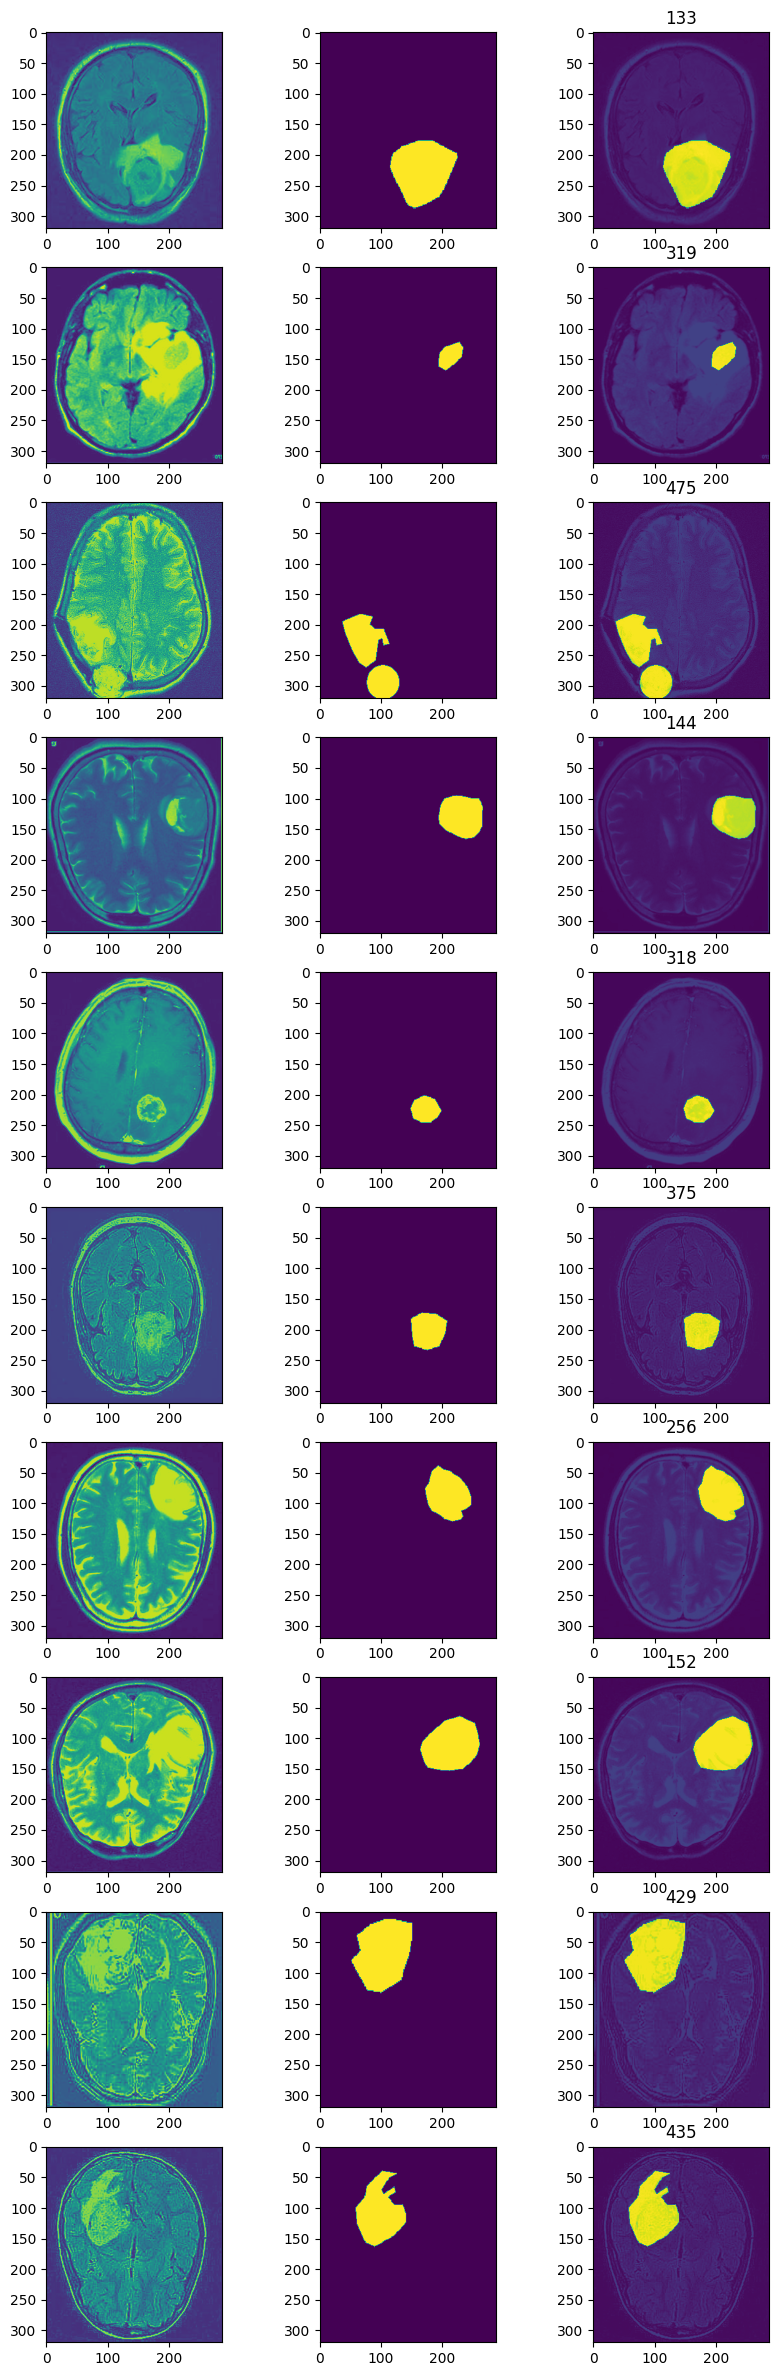

In [51]:
plt.figure(figsize=(10,30))
np.random.seed(25)
for i, randint in enumerate(np.random.randint(1, 501, size=10)):

    img = sio.imread(f'../data/mask/y{randint}.png', as_gray=True)
    mask = sio.imread(f'../data/mask/y{randint}_mask.png', as_gray=True)

    plt.subplot(10, 3, i*3+1)
    plt.imshow(img)

    plt.subplot(10, 3, i*3+2)
    plt.imshow(mask)

    plt.subplot(10, 3, i*3+3)
    plt.imshow(img + mask * 999)
    plt.title(randint)

Text(0.5, 1.0, '245')

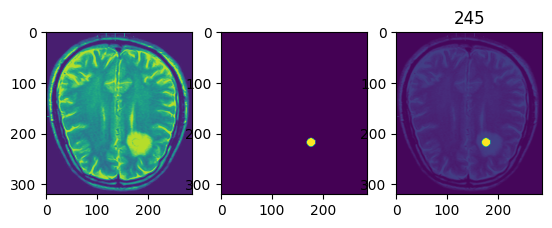

In [53]:
randint=245

img = sio.imread(f'../data/mask/y{randint}.png', as_gray=True)
mask = sio.imread(f'../data/mask/y{randint}_mask.png', as_gray=True)

plt.subplot(1, 3, 1)
plt.imshow(img)

plt.subplot(1, 3, 2)
plt.imshow(mask)

plt.subplot(1, 3, 3)
plt.imshow(img + mask * 999)
plt.title(randint)